# Location Based Clustering for the Yelp Academic Dataset
 Authors: Matt DiPietro, Rajshree Chauhan, Sindhuja Ramini, Jonathan Gee

# Introduction

This project utilizes the Yelp academic dataset found through https://www.yelp.com/dataset. It aims to use this dataset, which is a subset of the larger yelp dataset, and applies multiple clustering machine learning algorithms. Yelp is known as an industry leading company with millions of restaurant reviews, which provides us with an extensive and informative database for a restaurant recommendation engine. 

The original yelp academic dataset is split into 5 different JSON files. For our analysis, we used 1 of the original 5 files, business.json. The Business.json file has 59 different attributes and 188594 entries. However, the data is relatively sparse with many null entries for many of the attributes. 

# Data Cleaning

The first step we did was to convert the JSON files to a CSV file to make it easier to process. The yelp dataset has information on businesses other than restaurants. To filter this dataset to retrieve only businesses that are restaurants out we removed any entries within the business.csv file with a null for restaurant takeout. We also removed any permanently closed restaurants and restaurants without a price range to make the final dataset we used to have less null values.

In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
#Determined which businesses were restaturants
businesses = pd.read_csv('yelp_academic_dataset_business.csv')
businesses.dropna(subset=['attributes.RestaurantsTakeOut'], inplace=True)
businesses.dropna(subset=['attributes.RestaurantsPriceRange2'],inplace=True)
businesses.dropna(subset = ['latitude', 'longitude'], inplace=True)
print(businesses.shape)
businesses.head()

(58365, 59)


,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,...,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,...,11:0-21:0,1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB
1,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN,False,NaN,...,NaN,0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV
2,1335 rue Beaubien E,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,NaN,...,10:0-22:0,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
5,"20235 N Cave Creek Rd, Ste 1115",NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,...,5:30-20:0,1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,NaN,85024,63,4.0,AZ
7,"3417 Derry Road E, Unit 103",NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON


# Data Selection

The goal of this project is to cluster based on latitude and longitude in a given city to find which categories of food is more popular. Therefore the attributes we selected are business_id, name, categories, latitude, longitude, and city from the businesses dataset.

In [3]:
cleaned_businesses = businesses[['business_id','name','categories','latitude','longitude','city']]
cleaned_businesses.head()

,business_id,name,categories,latitude,longitude,city
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",51.091813,-114.031675,Calgary
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,"Chicken Wings, Burgers, Caterers, Street Vendo...",35.960734,-114.939821,Henderson
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,"Breakfast & Brunch, Restaurants, French, Sandw...",45.540503,-73.599300,Montréal
5,45bWSZtniwPRiqlivpS8Og,The Coffee Bean & Tea Leaf,"Coffee & Tea, Food",33.671375,-112.030017,Phoenix
7,6OuOZAok8ikONMS_T3EzXg,Thai One On,"Restaurants, Thai",43.712946,-79.632763,Mississauga


In [4]:
#Put the cleaned dataframe into csv so it can be used in another notebook if needed
cleaned_businesses.to_csv('cleaned_businesses.csv')
data = cleaned_businesses

# Clustering

Here, we set up some helper functions to display information on the clusters. label_count displays the counts in each cluster and print_Categories displays the top 5 restaurant categories for each cluster. 

In [5]:
#common category tags to ignore
ignore = ["Restaurants", "Food", "Nightlife"]
#prints the count of unique items in array label
def label_count(labels):
    lab_count = dict()

    for x in labels:
        if x in lab_count:
            lab_count[x] += 1
        else:
            lab_count[x] = 1

    print("Number of Clusters:", len(lab_count))
    for k, v in lab_count.items():
        print(k,"\t",v)
    return len(lab_count)


In [6]:
#prints the top 5 categories for each cluster
#grouped is an dataframe with "clusters" from 0 to n and "categories"
#n is the number of clusters
def print_Categories(grouped, n):

    cat_list = [dict() for x in range(n)]

    for index, row in grouped.iterrows():
        for x in range(n):
            if (row["clusters"] == x):
                cats = row["categories"]
                words = [x.strip() for x in cats.split(",")]
                for word in words:
                    if word not in ignore:
                        if word in cat_list[x]:
                            cat_list[x][word] += 1
                        else:
                            cat_list[x][word] = 1
                break


    for x in range(n):
        print("\n\n", x , "category dictionary")
        sorted_x = sorted(cat_list[x].items(), key=lambda kv: kv[1])
        sorted_x = list(reversed(sorted_x))
        for y in range(5):
            if(y < len(sorted_x)):
                print(sorted_x[y])
    return

In [7]:
data['city'].unique()

array(['Calgary', 'Henderson', 'Montréal', 'Phoenix', 'Mississauga',
       'Avondale', 'Toronto', 'Monticello', 'Streetsboro', 'Sun Prairie',
       'Las Vegas', 'Middlefield', 'Cleveland', 'Upper St Clair',
       'North York', 'Charlotte', 'Pittsburgh', 'Woodbridge', 'Thornhill',
       'Scottsdale', 'Glendale', 'Mesa', 'Laval', 'Brooklyn', 'Goodyear',
       'Mentor', 'Gilbert', 'Matthews', 'Ajax', 'Madison', 'Stouffville',
       'Monroe', 'Tempe', 'Brunswick', 'North Las Vegas', 'Mount Holly',
       'Scarborough', 'Swissvale', 'Dorval', 'Wesley Chapel', 'Oakville',
       'Brampton', 'Westlake', 'Kent', 'Cave Creek', 'Peoria',
       'Broadview Heights', 'Stow', 'East Mississauga', 'Chandler',
       'Markham', 'Imperial', 'Mayfield Heights', 'Gastonia', 'St-Jerome',
       'Irwin', 'University Heights', 'Cheswick', 'Pineville', 'Waxhaw',
       'Champaign', 'Montreal', 'Sainte-Julie', 'Millvale', 'Belmont',
       'Medina', 'Richmond Hill', 'Lasalle', 'Allison Park', 'McMurray'

In [8]:
#Prompt for city name. Choose from list below.
#List of cities available 
city = input("Enter a city ")

Enter a city Toronto


In [9]:
data = cleaned_businesses.loc[cleaned_businesses['city'] == city]

Since we are clustering based on location data, we have to separate the latitude and longitude out from the rest of the data.

In [10]:
#separate the checkin data to cluster on
lat_lon = data.iloc[:, 3:5]
lat_lon = lat_lon.fillna(0)


## K-means

The main clustering method we used was K-means. Here, we cluster the data using K-means with a cluster size of 8.

In [11]:
from sklearn.cluster import KMeans

In [12]:
n=8
cluster = KMeans(n_clusters = n, random_state = 0).fit(lat_lon)
labels = cluster.labels_

In [13]:
#display the clusters
print("\n\nClusters:")
label_count(labels)

#attach the clusters to other data
data["clusters"] = labels
info = ["categories", "name", "clusters"]
grouped = data[info]
grouped = grouped.fillna("")

info = ["latitude", "longitude", "clusters"]
#use for visualization
visualization_data = data[info]
visualization_data = visualization_data.fillna(0)

#print(grouped.head())
#display categories within clusters
print_Categories(grouped, n)



Clusters:
Number of Clusters: 8
0 	 1384
4 	 3111
1 	 594
6 	 397
5 	 613
7 	 355
2 	 268
3 	 893


/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  




 0 category dictionary
('Bars', 203)
('Coffee & Tea', 188)
('Breakfast & Brunch', 134)
('Italian', 121)
('Canadian (New)', 118)


 1 category dictionary
('Chinese', 165)
('Coffee & Tea', 47)
('Indian', 43)
('Desserts', 38)
('Fast Food', 37)


 2 category dictionary
('Coffee & Tea', 24)
('Middle Eastern', 22)
('Fast Food', 21)
('Mediterranean', 21)
('Specialty Food', 20)


 3 category dictionary
('Coffee & Tea', 101)
('Bars', 100)
('Breakfast & Brunch', 85)
('Canadian (New)', 75)
('Pizza', 65)


 4 category dictionary
('Coffee & Tea', 454)
('Bars', 368)
('Sandwiches', 289)
('Canadian (New)', 269)
('Breakfast & Brunch', 248)


 5 category dictionary
('Coffee & Tea', 69)
('Italian', 68)
('Japanese', 51)
('Bars', 50)
('Sushi Bars', 49)


 6 category dictionary
('Coffee & Tea', 59)
('Cafes', 36)
('Bars', 34)
('Specialty Food', 34)
('Breakfast & Brunch', 30)


 7 category dictionary
('Korean', 49)
('Chinese', 48)
('Coffee & Tea', 45)
('Japanese', 45)
('Desserts', 37)


We can see from the above results that there is a breakdown of types of food based on location. For example, cluster 2 has 2 types of middle eastern food, while cluster 7 has 3 types of asian food. This knowledge can then be used to find where certain types of food are popular within a specific city. 

In [14]:
import matplotlib.pyplot as plt

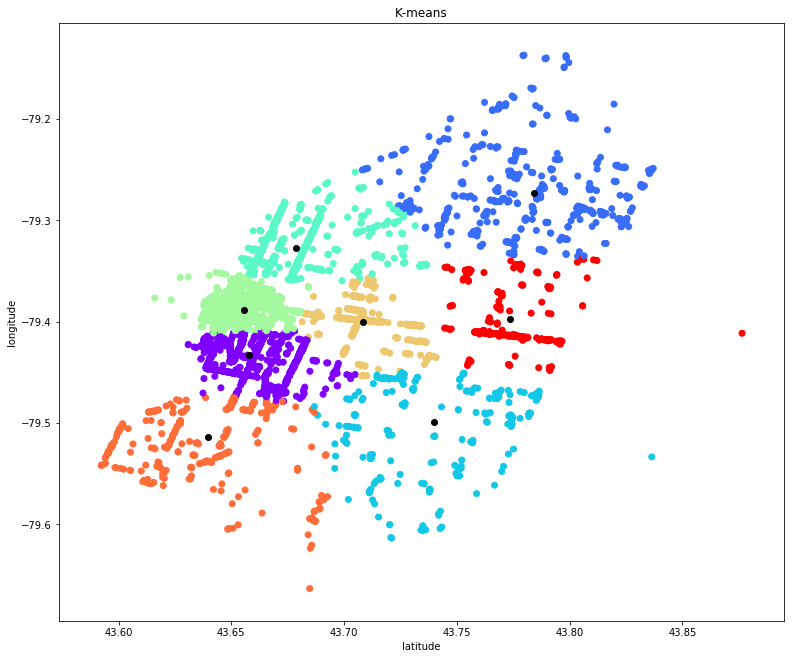

In [15]:
plt.figure(figsize=(13, 11))  
plt.scatter(visualization_data['latitude'], visualization_data['longitude'], c=visualization_data["clusters"], cmap='rainbow')    
plt.scatter(cluster.cluster_centers_[:,0] ,cluster.cluster_centers_[:,1], color='black') 
plt.figure(1, figsize=(12,2))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('K-means')
plt.show()


## Agglomerative 

Another clustering method we used was agglomerative clustering. We used euclidean distance and complete linkage to cluster on. This is similar to K-Means clustering as they both are a distance based clustering algorithm, but differ because K-means is a bottom-up approach. 

In [16]:
from sklearn.cluster import AgglomerativeClustering

In [17]:
cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='complete').fit(lat_lon)
labels = cluster.labels_

In [18]:
#display the clusters
print("\n\nClusters:")
label_count(labels)

#attach the clusters to other data
data["clusters"] = labels
info = ["categories", "name", "clusters"]
grouped = data[info]
grouped = grouped.fillna("")

info = ["latitude", "longitude", "clusters"]
#use for visualization
visualization_data = data[info]
visualization_data = visualization_data.fillna("")

#print(grouped.head())
#display categories within clusters
print_Categories(grouped, n)



Clusters:
Number of Clusters: 8
1 	 5192
6 	 975
3 	 432
7 	 70
5 	 230
2 	 488
0 	 177
4 	 51


/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  




 0 category dictionary
('Middle Eastern', 23)
('Mediterranean', 17)
('Coffee & Tea', 15)
('Sandwiches', 14)
('Fast Food', 13)


 1 category dictionary
('Coffee & Tea', 721)
('Bars', 623)
('Canadian (New)', 433)
('Breakfast & Brunch', 422)
('Sandwiches', 420)


 2 category dictionary
('Chinese', 159)
('Coffee & Tea', 39)
('Indian', 35)
('Desserts', 34)
('Specialty Food', 29)


 3 category dictionary
('Coffee & Tea', 69)
('Cafes', 39)
('Specialty Food', 36)
('Bakeries', 36)
('Pizza', 32)


 4 category dictionary
('Pizza', 7)
('Chinese', 6)
('Sandwiches', 6)
('Bars', 6)
('Coffee & Tea', 6)


 5 category dictionary
('Korean', 39)
('Chinese', 35)
('Japanese', 34)
('Coffee & Tea', 29)
('Desserts', 29)


 6 category dictionary
('Bars', 107)
('Coffee & Tea', 104)
('Breakfast & Brunch', 87)
('Canadian (New)', 74)
('Pizza', 69)


 7 category dictionary
('Indian', 12)
('Bars', 9)
('Halal', 8)
('Sandwiches', 8)
('American (Traditional)', 7)


We can see that agglomerative clustering produces a much bigger main cluster, probably clustering around the downtown area of the specific city.

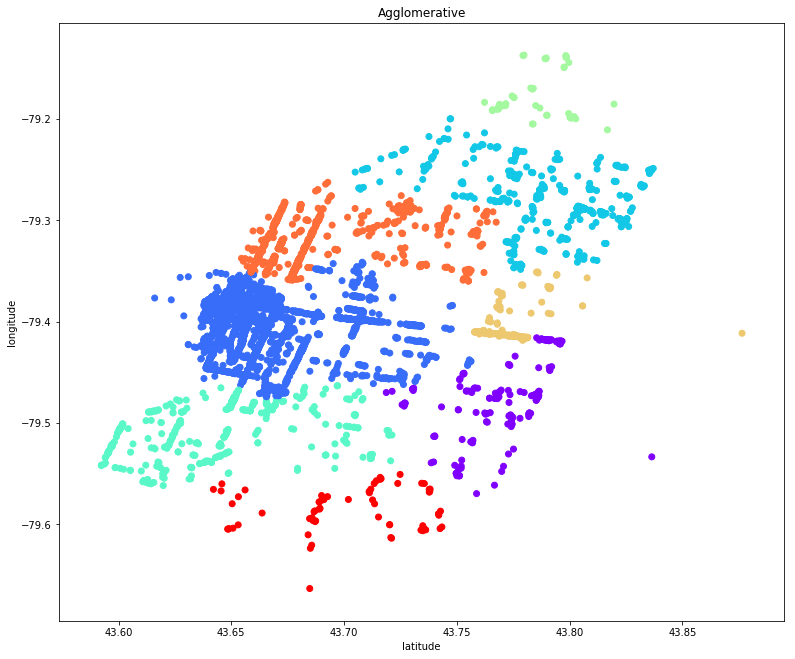

In [19]:
plt.figure(figsize=(13, 11))  
plt.scatter(visualization_data['latitude'], visualization_data['longitude'], c=visualization_data["clusters"], cmap='rainbow')    
plt.figure(1, figsize=(12,2))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Agglomerative')
plt.show()


## DBSCAN

A final clustering method we applied was DBScan, which is different than the other 2 methods. This one is based off of the density of the points, rather than the distance between them, so it provides a completely different approach. 

In [20]:
from sklearn.cluster import DBSCAN

In [21]:
labels = DBSCAN(eps = .01, min_samples = 10).fit(lat_lon)

In [22]:
labels = labels.labels_
#display the clusters
print("\n\nClusters:")
label_c = label_count(labels)

#attach the clusters to other data
data["clusters"] = labels
info = ["categories", "name", "clusters"]
grouped = data[info]
grouped = grouped.fillna("")

info = ["latitude", "longitude", "clusters"]
#use for visualization
visualization_data = data[info]
visualization_data = visualization_data.fillna("")

#print(grouped.head())
#display categories within clusters
print_Categories(grouped, label_c-1)



Clusters:
Number of Clusters: 22
0 	 5938
-1 	 291
1 	 211
2 	 166
3 	 17
4 	 223
5 	 154
6 	 341
7 	 31
8 	 45
15 	 13
9 	 19
10 	 30
11 	 12
19 	 11
12 	 34
13 	 17
14 	 10
20 	 12
16 	 14
17 	 11
18 	 15


/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys




 0 category dictionary
('Coffee & Tea', 819)
('Bars', 718)
('Breakfast & Brunch', 498)
('Canadian (New)', 490)
('Sandwiches', 471)


 1 category dictionary
('Coffee & Tea', 34)
('Cafes', 19)
('Breakfast & Brunch', 19)
('Pizza', 15)
('Specialty Food', 15)


 2 category dictionary
('Pizza', 16)
('Sushi Bars', 15)
('Japanese', 15)
('Canadian (New)', 15)
('Italian', 14)


 3 category dictionary
('American (Traditional)', 5)
('Canadian (New)', 5)
('Bars', 5)
('Seafood', 3)
('Steakhouses', 2)


 4 category dictionary
('Korean', 43)
('Desserts', 31)
('Japanese', 30)
('Chinese', 29)
('Bars', 26)


 5 category dictionary
('Chinese', 82)
('Desserts', 18)
('Japanese', 13)
('Korean', 10)
('Barbeque', 10)


 6 category dictionary
('Chinese', 54)
('Coffee & Tea', 35)
('Fast Food', 30)
('Middle Eastern', 24)
('Bakeries', 24)


 7 category dictionary
('Bars', 4)
('Italian', 4)
('Pizza', 4)
('Fast Food', 3)
('Burgers', 3)


 8 category dictionary
('Middle Eastern', 10)
('Mediterranean', 9)
('Breakfas

We can see that this method creates a large main cluster and many small clusters. This method also does not create a specified amount of clusters, rather, it creates clusters based on the input parameters. This method also allows us to do outlier detection, since any restaurant not in a cluster is labeled -1.

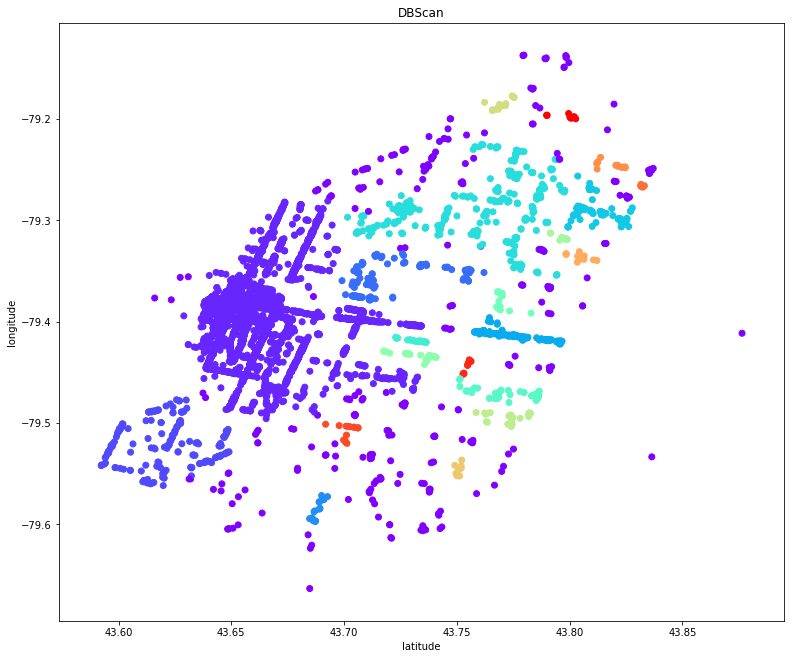

In [23]:
plt.figure(figsize=(13, 11))  
plt.scatter(visualization_data['latitude'], visualization_data['longitude'], c=visualization_data["clusters"], cmap='rainbow')    
plt.figure(1, figsize=(12,2))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('DBScan')
plt.show()

In [24]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [25]:
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [26]:
grouped.head()

,categories,name,clusters
11,"Cajun/Creole, Southern, Restaurants",Southern Accent Restaurant,0
23,"Food, Bakeries, Coffee & Tea",Mabel's Bakery,0
27,"Restaurants, Food, Canadian (New), Coffee & Tea",The Coffee Mill Restaurant,0
80,"Caribbean, Food, Bakeries, Restaurants",Allwyn's Bakery,-1
88,"Restaurants, Food, Coffee & Tea, Breakfast & B...",Hub Coffee House & Locavorium,0


Find the frequent itemsets and association rules.

In [33]:
word_dict = dict()
for index, row in grouped.iterrows():
    cats = row["categories"]
    words = [x.strip() for x in cats.split(",")]
    for x in words:
        if x not in ignore:
            if x in word_dict:
                word_dict[x] += 1
            else:
                word_dict[x] = 1

basket = pd.DataFrame(index = np.arange(len(grouped)), columns = word_dict.keys())
print(basket.shape)

temp = 0
for index, row in grouped.iterrows():
    cats = row["categories"]
    words = [x.strip() for x in cats.split(",")]
    for x in words:
        if x not in ignore:
            basket.iloc[temp][x] = 1
    temp += 1

basket = basket.fillna(0)
basket.head()


(7615, 347)


,Cajun/Creole,Southern,Bakeries,Coffee & Tea,Canadian (New),Caribbean,Breakfast & Brunch,Wine Bars,Indian,Bars,...,Discount Store,Car Wash,Reunion,Parks,Izakaya,Churches,Herbal Shops,Acupuncture,Pretzels,Egyptian
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.054235,(Bakeries)
1,0.129613,(Coffee & Tea)
2,0.075640,(Canadian (New))
3,0.075246,(Breakfast & Brunch)
4,0.036113,(Indian)
5,0.108339,(Bars)
6,0.041234,(American (Traditional))
7,0.051609,(Burgers)
8,0.050033,(Fast Food)
9,0.073408,(Sandwiches)


In [35]:
# Create the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee & Tea),(Cafes),0.129613,0.068155,0.034406,0.265451,3.894814,0.025572,1.268595
1,(Cafes),(Coffee & Tea),0.068155,0.129613,0.034406,0.504817,3.894814,0.025572,1.757708
2,(Bars),(Canadian (New)),0.108339,0.075640,0.032305,0.298182,3.942109,0.024110,1.317093
3,(Canadian (New)),(Bars),0.075640,0.108339,0.032305,0.427083,3.942109,0.024110,1.556354
